In [1]:
# Software Name : HSLinUCB
# SPDX-FileCopyrightText: Copyright (c) 2021 Orange
# SPDX-License-Identifier: GPL-2.0
#
# This software is distributed under the GNU General Public License v2.0 license
#
# Author: David DELANDE <david.delande@orange.com> et al.

## This jupyter notebook requires a Deep Q-Learning model. Executes dqn_coldstart.ipynb to generate a model.

In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [3]:
%load_ext autoreload
%autoreload 2
import time
import seaborn as sns
import json
import numpy as np
import math
from math import *
import scipy.stats as stats
from numpy.linalg import inv
%matplotlib notebook
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from IPython.display import clear_output
import matplotlib
import random
import numpy.linalg
import copy
import pandas as pd
pd.set_option('display.max_columns', None)
from tqdm import trange
plt.rcParams.update({'figure.max_open_warning': 0})
import sys
np.set_printoptions(threshold=sys.maxsize)
np.random.seed(1)
import tensorflow as tf
from tensorflow import keras
from keras import backend as Kb
tf.compat.v1.set_random_seed(1)
import pickle
from collections import deque , OrderedDict
from numpy import asarray
from numpy import save
import h5py
from lib.CogscalingLib import Orchestrator

Using TensorFlow backend.


## Dataset

In [4]:
sessionFile="D1.h5" #Set the dataset to use. Other possible dataset: D2.h5. For ColdStart and hotstart seen uses D1.h5. For hotstart unseen uses D2.h5
environment_orchestrator = Orchestrator(debug=False, sessionFile=sessionFile)

OrchestratorActionResult thread : started
Orchestrator: wait 2 seconds for kafka initialization...
StateResult thread : started
State result: wait 2 seconds for kafka initialization...


## Environment

In [5]:
class EnvTest():

    
    def __init__(self, narms, level=1,max_level = 25, latency_ref = 600, debug = False):
        self.latency_ref = latency_ref
        self.min_level = 1
        self.max_level = max_level
        self.level = level
        self.debug = debug
        self.narms = narms
        self.loads = [5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,95,100]
        self.levels = [1,2,3,4,5,6,7,8,9,10]
        self.sessionFile=sessionFile
        self.oracle_cheat = np.full((np.max(self.loads) +1, len(self.levels) + 1),2)
        self.previous_states = []
        self.current_states = []
        self.previous_duration = 0
        self.current_duration = 0
        self.previous_rq = 0
        self.current_rq = 0
        self.targetPattern = []
        self.rounds = 0
        self.replay = True
        self.record = False
        super().__init__()
        return
    
    def reset(self, narms, target, level,max_level, latency_ref):
        self.level = level
        self.rounds = 0
        self.step = 0
    
    def moving_mean(self,measure,order):
        result = []
        if order%2 == 0:
            m = order / 2
            m = int(m)
            for index in range(0, len(measure)):
                if index < m or index + m + 1 > len(measure):
                    continue
                sum1 = 0
                sum2 = 0
                for index_value in range(index -m, index + m):
                    sum1 = sum1 + measure[index_value]
                    sum2 = sum2 + measure[index_value + 1]
                mean1 = (1/(2*m)) * sum1
                mean2 = (1/(2*m)) * sum2
                result.append((mean1 + mean2) / 2)
        else:
            m = (order - 1) / 2
            m = int(m)
            for index in range(0, len(measure)):
                if index < m or index + m + 1 > len(measure):
                    continue   
                sum1 = 0
                for index_value in range(index - m, index + m + 1):
                    sum1 = sum1 + measure[index_value]
                result.append((1/((2*m)+1)) * sum1)
        return result
    
    def save_PatternModel(self,file = ''):
        #Save the target pattern to a json file
        if file == '':
            file = 'pattern'
        with open(file + '.json', 'w') as filehandle:
            json.dump(self.targetPattern, filehandle)

    def load_PatternModel(self, file = ''):
        #Load the target pattern from a json file
        if file == '':
            file = 'pattern'
        with open(file + '.json') as json_file:
            self.targetPattern = json.load(json_file)
        return self.targetPattern
    
    def display_PatternModel(self):
        #Generate the target pattern graph
        f = plt.figure()
        patternGraph = f.add_subplot(111)
        patternGraph.plot(self.targetPattern)
        plt.ylabel("Number of users",fontsize=16)
        plt.xlabel("Steps",fontsize=16)
        plt.title("Workload injection pattern");
        plt.grid();
        plt.show()
    
    def generateRealProgressiveTargetPattern(self,nrounds,step,target_list):
        #Generate the target pattern
        self.targetPattern = []
        patternChangeNumber = math.floor(nrounds/step)

        target = target_list[0]
        target_list_index = 0
        mode = 1 #1 for increase, 0 for decrease
        p_c = 1
        for n in range(nrounds): 
                if n < (p_c * step):
                    self.targetPattern.append(target)
                elif p_c <= patternChangeNumber:
                    p_c = p_c + 1
                    if mode == 1:
                        if target_list_index < (len(target_list) - 1):
                            target_list_index += 1
                        else:
                            mode = 0
                    else:
                        if target_list_index > 0:
                            target_list_index -= 1
                        else:
                            mode = 1
                    target = target_list[target_list_index]
                    self.targetPattern.append(target)
                else:
                    self.targetPattern.append(target)
        return self.targetPattern
    
    def changeInjector(self):
        user_level = self.targetPattern[self.rounds]
        if self.debug:
            print("injector level:", user_level)
        if self.replay == False:
            status, message = environment_orchestrator.setLocustUser(user=int(user_level),spawn_rate=1)
            print("message:", message)
                                    
    def getContext(self):
        states = []  
        if len(self.previous_states) == 0:
            state = environment_orchestrator.getAgregatedState(components=[{'prometheus': 'front-dynamic-component','zipkin': 'front-dynamic-component-service.default.svc.cluster.local:80/*'}],replay=self.replay, record=self.record,load=self.targetPattern[self.rounds], level=self.level,useMetricServer = False)
            self.previous_states.append(state['lastcomponentNumber'].to_numpy().astype(float)[0])
            self.previous_states.append(state['duration'].to_numpy().astype(float)[0])
            self.previous_duration = state['duration'].to_numpy().astype(float)[0]
            self.previous_states.append(state['req_perc_sec'].to_numpy().astype(float)[0])
            self.previous_rq = state['req_perc_sec'].to_numpy().astype(float)[0]
            self.previous_states.append(state['cpu_perc_request_mean'].to_numpy().astype(float)[0])
            self.previous_states.append(state['cpu_perc_limit_mean'].to_numpy().astype(float)[0])
            self.previous_states.append(state['mem_perc_request_mean'].to_numpy().astype(float)[0])
            self.previous_states.append(state['mem_perc_limit_mean'].to_numpy().astype(float)[0])
        elif len(self.previous_states) != 0 and len(self.current_states) != 0:
            self.previous_states = self.current_states
            self.previous_duration = self.current_duration
            self.previous_rq = self.current_rq

        self.current_states = []
        state = environment_orchestrator.getAgregatedState(components=[{'prometheus': 'front-dynamic-component','zipkin': 'front-dynamic-component-service.default.svc.cluster.local:80/*'}],replay=self.replay, record=self.record,load=self.targetPattern[self.rounds], level=self.level,useMetricServer = False)


        response_times = state['response_times'][0] 
        num_reqs_perc_sec = state['num_reqs_per_sec'][0]
        num_fail_per_sec = state['num_fail_per_sec'][0]
        self.current_states.append(state['lastcomponentNumber'].to_numpy().astype(float)[0] / self.max_level)
        self.level = int(state['lastcomponentNumber'].to_numpy().astype(float)[0])
        self.current_states.append(state['duration'].to_numpy().astype(float)[0] / 20000)
        self.current_duration = state['duration'].to_numpy().astype(float)[0]
        self.current_states.append(state['req_perc_sec'].to_numpy().astype(float)[0] / 100)
        self.current_rq = state['req_perc_sec'].to_numpy().astype(float)[0]
        self.current_states.append(state['cpu_perc_request_mean'].to_numpy().astype(float)[0])
        self.current_states.append(state['cpu_perc_limit_mean'].to_numpy().astype(float)[0])
        self.current_states.append(state['mem_perc_request_mean'].to_numpy().astype(float)[0])
        self.current_states.append(state['mem_perc_limit_mean'].to_numpy().astype(float)[0])
        if self.debug:
            print("previous states in getcontext:", self.previous_states)
            print("current states in getcontext:", self.current_states)
        global_states = np.concatenate((self.previous_states,self.current_states), axis=None)
        states = self.current_states
        states = np.asmatrix(states)
        if self.debug:
            print("state returned:", states)
            
        return states
    
    def armStay(self,context):
        if self.debug:
            print("In action stay function")
            print("level in armStay:", self.level)
        previous_context = context
        reward = self.computeReward(previous_context=previous_context,context = context, action = "stay",actionStep = 0)
        return reward, context
        
    def armUp(self,context,actionStep = 1):
        previous_context = context
        if self.debug:
            print("In action up function")
            print("actionStep:", actionStep)
            print("level in armUp:", self.level)
        if self.level + actionStep > self.max_level:
            if self.debug:
                print("upper limit reached")
            reward = 0
        else:
            if self.replay:
                self.level += actionStep
            else:
                status, message = environment_orchestrator.incrementalKubernetesDeploymentScale(deployment="front-dynamic-component",step=actionStep,waitKubernetes=True,waitPrometheus=True,useMetricServer = False)
                print("message:", message)
            context = self.getContext()
            reward = self.computeReward(previous_context = previous_context,context = context, action = "up",actionStep = actionStep)
        return reward,context
    
    def armDown(self,context, actionStep = 1):
        previous_context = context
        if self.debug:
            print("In action down function")
            print("actionStep:", actionStep)
            print("level in armDown:", self.level)
        if self.level + actionStep < self.min_level:
            if self.debug:
                print("lower limit reached")
            reward = 0
        else:
            if self.debug:
                print("lower limit not reached")
            if self.replay:
                self.level += actionStep
            else:
                status, message = environment_orchestrator.incrementalKubernetesDeploymentScale(deployment="front-dynamic-component",step=actionStep,waitKubernetes=True,waitPrometheus=True,useMetricServer = False)
                print("message:", message)
            context = self.getContext()
            reward = self.computeReward(previous_context = previous_context,context = context, action = "down",actionStep = actionStep)
        return reward,context
    
    def computeReward(self,previous_context,context, action,actionStep = 1):
        if self.debug:
            print("in compute reward function")
        if action == "up":    

            if self.debug:
                print("compute reward for action up")
                print("previous latency for reward computation:", self.previous_duration)
                print("latency for reward computation:", self.current_duration)

            if self.previous_duration > self.latency_ref:
                reward = 1
            else:
                reward = 0

        if action == "down":
            if self.debug:
                print("compute reward for action down")
                print("previous latency for reward computation:", self.previous_duration)
                print("latency for reward computation:", self.current_duration)

            if self.current_duration <= self.latency_ref:
                reward = 1
            else:
                reward = 0
                    
        if action == "stay":

            if self.debug:
                print("Compute reward for action stay")
                print("previous latency for reward computation:", self.previous_duration)
                print("latency for reward computation:", self.current_duration)

            if self.current_duration <= self.latency_ref:
                reward = 1
            else:
                reward = 0
        if self.debug:
            print("returned reward:", reward)
        return reward
        
    def computeOracle(self):
        with h5py.File(self.sessionFile, "r") as f:
            for load in self.loads:
                bestset = False
                for level in self.levels:
                    load_grp = f.get(str(load))
                    component_grp = load_grp.get('front-dynamic-component')
                    level_grp = component_grp.get(str(level))
                    d = level_grp.get('measure')
                    data = np.asarray(d)
                    duration = data[:,3].astype(float)
                     
                    if np.mean(duration) <= self.latency_ref and np.max(duration) <= self.latency_ref:
                        if not bestset:
                            self.oracle_cheat[load,level] = 1
                            bestset = True
                        else:
                            self.oracle_cheat[load,level] = 0
            if self.debug:
                print("oracle cheat:", self.oracle_cheat)

    def oracle(self):
        #Return the Oracle best action
        return self.oracle_cheat[int(self.targetPattern[self.rounds]),int(self.level)]
    
    def oracleOptimalLevel(self):
        #Return the Oracle best action
        return np.where(self.oracle_cheat[int(self.targetPattern[self.rounds])] == 1)[0][0]
    



## Generate progressive pattern

<IPython.core.display.Javascript object>


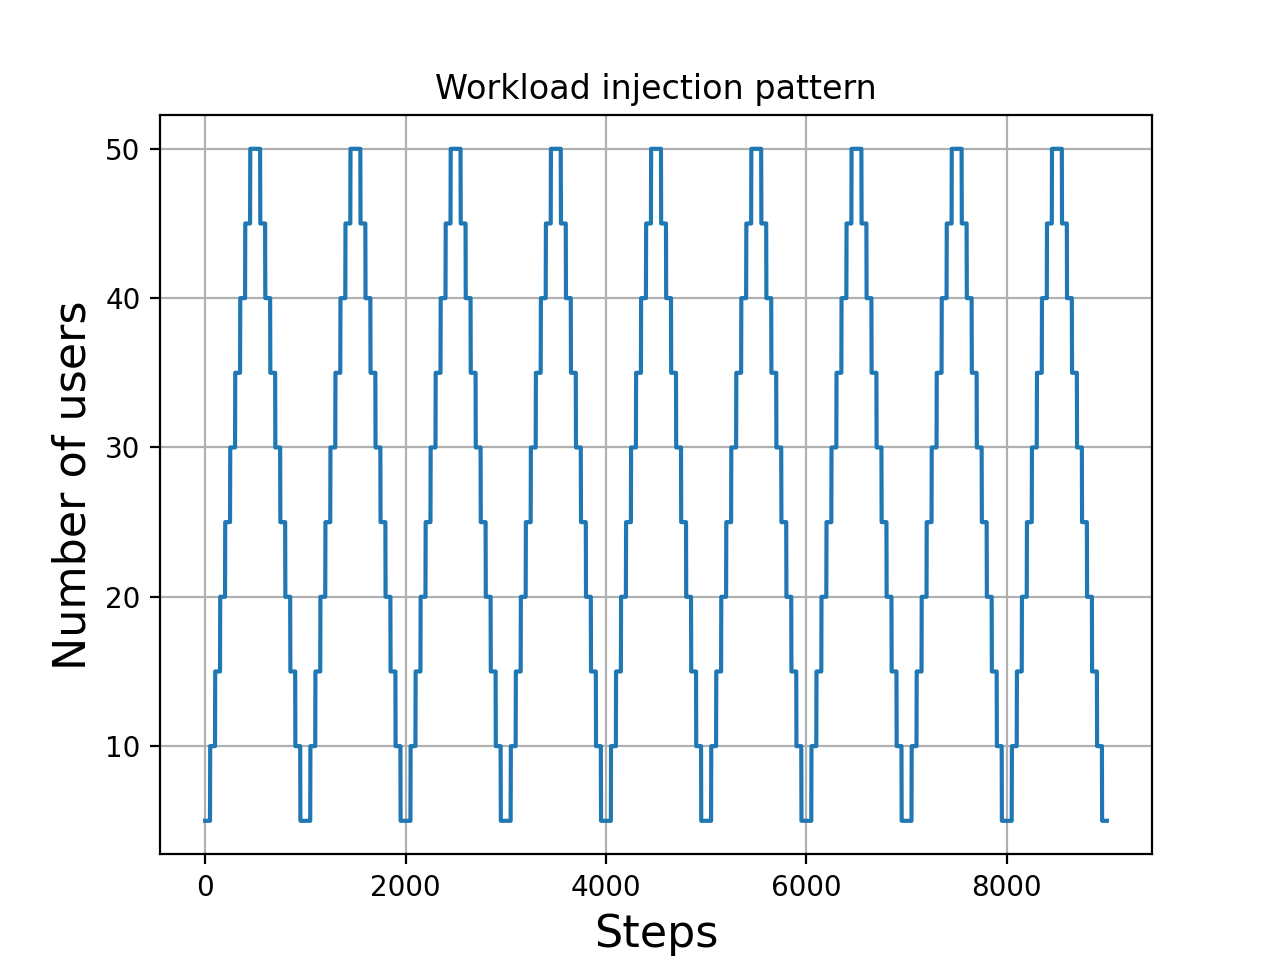

In [6]:
nrounds = 9000 #2400 #Number of step pattern to generate. It must be the same as the one that will be used in simulation
randomTargetStep = 50 #The pattern will change every randomTargetStep

target_list = [5,10,15,20,25,30,35,40,45,50]
#Generate the environment
Environment = EnvTest(narms=3,level=1,max_level = 4)
#Generate the pattern
pattern = Environment.generateRealProgressiveTargetPattern(nrounds = nrounds,step = randomTargetStep, target_list = target_list)
Environment.save_PatternModel()
#Load pattern from a json file(pattern.json). This method has to be called each time an environment needs to use the target pattern
Environment.load_PatternModel()
#Display graphically the target pattern model
Environment.display_PatternModel()

In [ ]:
def Evaluate(Environment, Agent, nrounds=None, tie_break_mode = "random",DisplayCumulativeRewardGraph = False, debug = False):

    environment_level = []
    optimal_environment_level = []
    latency_history = []
    latency_ref_history = []
    injector_level = []

    T = 0

    for i in range(nrounds):

        Environment.rounds = i
        Environment.changeInjector()
        
        
        context = Environment.getContext()
        optimal_environment_level.append(Environment.oracleOptimalLevel())
        if Environment.current_duration > Environment.latency_ref:
            reward,next_context = Environment.armUp(context = context,actionStep = 1)
        else:
            action, estimated_reward, confidence = Agent.select(context,tie_break_mode)
            if action == 0 :
                reward,next_context = Environment.armDown(context = context,actionStep = -1)

            if action == 1: 
                reward,next_context = Environment.armStay(context = context)
            Agent.observe(action, context,next_context, reward, update = True)

        latency_history.append(Environment.current_duration)
        injector_level.append(Environment.targetPattern[i])
        latency_ref_history.append(Environment.latency_ref)
        environment_level.append(Environment.level)

        T +=1
        if (DisplayCumulativeRewardGraph and T %1000 == 0):
            %matplotlib inline
            clear_output(True)
            fig, ax = plt.subplots(figsize=(6, 4), nrows=1, ncols=1)
            plt.xlabel('steps',fontsize=16)
            plt.ylabel("Number of users",fontsize=16)
            plt.xticks(fontsize=13,fontweight='normal')
            plt.yticks(fontsize=13,fontweight='normal')
            ax.plot(injector_level)
            ax.grid()
            ax.set_title('Simulation hotstart seen contexts injection pattern')
            plt.tight_layout()
            plt.show()
            fig, ax = plt.subplots(figsize=(6, 4), nrows=1, ncols=1)
            plt.xlabel('steps',fontsize=16)
            plt.ylabel("Number of containers",fontsize=16)
            plt.xticks(fontsize=13,fontweight='normal')
            plt.yticks(fontsize=13,fontweight='normal')
            ax.plot(environment_level,label='dqn')
            ax.plot(optimal_environment_level,label='Oracle')
            ax.grid()
            ax.set_title('simulation hotstart seen contexts environment level')
            plt.tight_layout()
            plt.legend(loc = 'upper right',prop={'size':20})
            plt.show()
            fig, ax = plt.subplots(figsize=(6, 4), nrows=1, ncols=1)
            plt.xlabel('steps',fontsize=16)
            plt.ylabel("Latency(ms)",fontsize=16)
            plt.xticks(fontsize=13,fontweight='normal')
            plt.yticks(fontsize=13,fontweight='normal')
            ax.plot(latency_history,label='dqn')
            ax.plot(latency_ref_history,label=r'$l^{*}$')
            ax.grid()
            ax.set_title('simulation hotstart seen context latency')
            plt.tight_layout()
            plt.legend(loc = 'upper right',prop={'size':20})
            plt.show()

    return injector_level,latency_ref_history,latency_history, environment_level, optimal_environment_level

## Deep QLearning

In [ ]:
class DeepQNetwork:
    def __init__(self, K, D, alpha = 0.1, epsilon = 0.9, gamma = 0.9, epsilon_max = 1, epsilon_increment = 0.01,reward_mode = "linear", fill_memory = True, learn = True,replace_target_iter=100,batch_size=3000):
        self._K = K
        self._D = D
        self.epsilon_start = epsilon
        self.learn = learn
        self.reward_mode = reward_mode
        self.loss_history = []
        self.reset()
        
        self.variables_list = ['s','s_','a','r']
        self.n_actions = K
        self.n_features = D
        self.lr = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_max = epsilon_max
        self.replace_target_iter = replace_target_iter
        self.batch_size = batch_size
        self.epsilon_increment = epsilon_increment
        #Memory section
        self.batch_size = batch_size
        self.counter = 0
        self.mem = pd.DataFrame(dtype=np.float64)
        self.batch_memory = OrderedDict()
        
        # total learning step
        self.learn_step_counter = 0

        # reduce keras overhead
        tf.compat.v1.disable_eager_execution()

        # Q Network weights filename
        self.weights_file = 'dqn_model_dump_coldstart.h5'
        self.q_model = self.build_neural_net()
        # target Q Network
        self.target_q_model = self.build_neural_net()
        # copy Q Network params to target Q Network
        self.replace_target_network()
        print("Agent init done")
        
    def reset(self):
        return 0
    
    def save_model(self):
        #This function saves the neural network model (weights)
        self.q_model.save_weights(self.weights_file)
        print("Neural network saved")
        
    def load_model(self):
        #This function restores a neural network model (weights)
        print("loading model")
        self.q_model.load_weights(self.weights_file)
        self.replace_target_network()
        print("Neural network loaded")
    
    def export_model(self):
        #model_theta and q_table are only here for signature compatibility
        model_theta = []
        q_table = []
        return q_table, model_theta

    def build_neural_net(self):
        init = tf.keras.initializers.HeUniform()
        model = keras.Sequential()
        model.add(keras.layers.Dense(24, input_shape=(self.n_features,), activation='relu', kernel_initializer=init))
        model.add(keras.layers.Dense(12, activation='relu', kernel_initializer=init))
        model.add(keras.layers.Dense(self.n_actions, activation='linear', kernel_initializer=init))
        model.compile(loss=tf.keras.losses.Huber(), optimizer=tf.keras.optimizers.Adam(lr=self.lr), metrics=['accuracy'])
        return model

    def store_transition(self, s, a, r, s_, clean=False):
        state = np.ravel(s)
        state = np.append(state,a)
        state = np.append(state,r)
        state = np.append(state,np.ravel(s_))
        memory = pd.DataFrame([state], dtype=np.float64)
        self.mem = self.mem.append(memory, ignore_index=True)
        if (clean):
            self.clean_memory()
                  
    def clean_memory(self):
        #This function removes all duplicates transition from memory
        self.mem.drop_duplicates(subset=None, inplace=True)
    
    def save_memory(self,json=False):
        #This function saves the memory in a json format if json=True or in binary format
        self.clean_memory()
        if (json):
            self.mem.to_json (r'./dqn_memory_dump_coldstart.json')
            print("Memory saved in json")
        else:
            with open('dqn_memory_dump_coldstart.bin', 'wb') as memory_save_dump:
                pickle.dump(self.mem, memory_save_dump)
            print("Memory saved in binary")

    def load_memory(self,json=False):
        #This function loads a json file into memory if json=True or from a binary file
        if (json):
            self.mem = pd.read_json(r'./dqn_memory_dump_coldstart.json')
            print("Memory loaded from json file")
        else:
            with open('dqn_memory_dump_coldstart.bin', 'rb') as memory_load_dump:
                self.mem = pickle.load(memory_load_dump)
            print("Memory loaded from binary file")

    def dump_memory(self):
        #This function display the memory content
        print("MEMORY DUMP:" + str(self.mem))
            
    def batch_sample(self):
        #This function retrieves a batch of transition from memory
        self.counter = len(self.mem)
        if(self.counter < self.batch_size): # Less transitions in memory than requested batch size
            sample_index = np.random.choice(np.arange(self.counter), size=self.counter,replace = False)
        else: #Enough transitions in memory so retrieves a full batch size
            sample_index = np.random.choice(np.arange(len(self.mem)), size=self.batch_size,replace = False)
        random.shuffle(sample_index)
        self.batch_memory['s'] = np.array(self.mem.iloc[sample_index, 0:(self.n_features)])
        self.batch_memory['a'] = np.array(self.mem.iloc[sample_index, (self.n_features)])
        self.batch_memory['r'] = np.array(self.mem.iloc[sample_index, (self.n_features) + 1])
        self.batch_memory['s_'] = np.array(self.mem.iloc[sample_index, (self.n_features) + 2:])
        return self.batch_memory
    
    def select(self, context, tie_break_mode = "random"):
        observation = context
        action = self.select_next_action(observation, tie_break_mode = tie_break_mode)
        value = np.zeros(self._K) #Not used. Only here for global evaluation compatibility
        confidence = np.zeros(self._K) #Not used. Only here for global evaluation compatibility
        return int(action), value, confidence
        
    def select_next_action(self, context, tie_break_mode = "random"):
        if (np.shape(context)[0] != 1):
            context = context[np.newaxis, :]
        if np.random.uniform() < self.epsilon:
            q_values = self.q_model.predict(context)
            action = np.argmax(q_values)
        else: #random action
            action = np.random.randint(0, self.n_actions)
        return int(action)

    def replace_target_network(self):
        #This function copy weights to target network weights.
        print("target network updated!")
        self.target_q_model.set_weights(self.q_model.get_weights())
    
    def increment_epsilon(self):
        #This function increments current epsilon with epsilon_increment value up to epsilon_max
        if (self.epsilon < self.epsilon_max):
            #Increment epsilon
            self.epsilon += self.epsilon_increment
        else:
            #Force epsilon to epsilon_max
            self.epsilon = self.epsilon_max
    
    #def learn(self):
    def observe(self, played_arm, context, next_context,reward, update = False):
        #This is the main learning function
        if self.learn_step_counter % 500 == 0 and (fill_memory or learn):
            self.clean_memory() #Remove duplicate entry in memory
            print("memory cleaned")
            print("memory size:", len(self.mem))
        if fill_memory:
            self.store_transition(context, played_arm, reward, next_context,clean=False) #Store transition in memory
        # check to replace fixed target network weights
        if learn and self.learn_step_counter % 5 and len(self.mem) >= self.batch_size:
            if self.learn_step_counter % self.replace_target_iter == 0:
                self.replace_target_network()
        
            batch_transition = self.batch_sample() #Retrieves a batch from memory
        
            q_next = self.target_q_model.predict(batch_transition['s_'])
            q_eval = self.q_model.predict(batch_transition['s'])
            q_target = q_eval.copy()
            batch_index = np.arange(len(batch_transition['s']), dtype=np.int32)
            eval_act_index = batch_transition['a'].astype(int)
            reward = batch_transition['r']
            q_target[batch_index, eval_act_index] = reward + self.gamma * np.max(q_next, axis=1)
            history = self.q_model.fit(batch_transition['s'],
                             q_target,
                             batch_size=len(batch_transition['s']),
                             epochs=1,
                             verbose=0)
            self.loss_history.append(history.history['loss'][0])
        self.learn_step_counter += 1
        self.increment_epsilon()

## Exploit deep qlearning in hotstart with already seen contexts

In [ ]:
mode='hotstart_seen'
debug = False
starting_level = 1 #The environement will start at this specified level
max_level = 10 #The number of levels that can be managed in the environment
latency_ref = 600
#Agent setup
nrounds = 9000
learning_step = 0
alpha = 0.01
gamma = 0.9
replace_target_iter=100
batch_size=50
Arms=2 #Number of actions (must be impair)
#Exploration rate will vary between "starting_exploration" and "stopping_exploration". The exploration rate will be increase at each round by increase_exploration_step
starting_exploration = 1 #Starting exploration rate.Must be between 0 and 1
stopping_exploration = 1 #Max value for exploration rate. Must be between 0 and 1
increase_exploration_step =   0 #value added to current exploration rate at each step. Set to 0 for fixed exploration rate.
tie_break_mode = "random" #Action selection mode when tied. Possible value: "random", "min", "max"
displayDynamicGraph = True #If True display regret and environment change dynamicaly. This dramatically increases the simulation time. Change this value require a full restart of the notebook as the graphic rendering engine change.
fill_memory = True
learn = True
ExperimentNumber = 10
environment_level_exp = np.empty((ExperimentNumber, nrounds))
optimal_environment_level_exp = np.empty((ExperimentNumber, nrounds))
latency_exp = np.empty((ExperimentNumber, nrounds))
latency_reference_exp = np.empty((ExperimentNumber, nrounds))
injector_level_exp = np.empty((ExperimentNumber, nrounds))
for experiment in trange(ExperimentNumber):
    #Create the environment
    Environment = EnvTest(Arms,level=starting_level,max_level = max_level,latency_ref = latency_ref, debug = debug)
    Environment.load_PatternModel()
    Environment.computeOracle()
    #Create agent
    Agent = DeepQNetwork(Arms, D = 7, alpha = alpha, epsilon = starting_exploration, gamma = gamma, epsilon_max = stopping_exploration, epsilon_increment = increase_exploration_step,learn = learn, fill_memory = fill_memory,replace_target_iter=replace_target_iter,batch_size=batch_size)
    Agent.load_model()
    Agent.load_memory()
    #Start simulation
    injector_level,latency_ref_history,latency, environment_level, optimal_environment_level = Evaluate(Environment, Agent, nrounds=nrounds, tie_break_mode=tie_break_mode,DisplayCumulativeRewardGraph = displayDynamicGraph, debug = debug)
    injector_level_exp[experiment] = injector_level
    latency_reference_exp[experiment] = latency_ref_history
    latency_exp[experiment] = latency
    environment_level_exp[experiment] = environment_level
    optimal_environment_level_exp[experiment] = optimal_environment_level
with open("deepqlearning_injector_level_" + mode + ".bin", 'wb') as f:
    np.save(f , injector_level_exp)
with open("deepqlearning_latency_reference_" + mode + ".bin", 'wb') as f:
    np.save(f , latency_reference_exp)
with open("deepqlearning_latency_" + mode + ".bin", 'wb') as f:
    np.save(f , latency_exp)
with open("deepqlearning_environment_level_" + mode + ".bin", 'wb') as f:
    np.save(f , environment_level_exp)
with open("deepqlearning_optimal_environment_level_" + mode + ".bin", 'wb') as f:
    np.save(f , optimal_environment_level_exp)